

Metrics that I might implement:

https://www.kdnuggets.com/2018/04/right-metric-evaluating-machine-learning-models-1.html

to do list:



*   Implement the new metrics from the papers, put them into the tables, and comparate them.

* Find a way to test more hyperparameters faster and search about "BayeSearch".

* Create a function that generates two samples of size n with the best neural network model from each set of simulations and apply hypothesis testing in order to ensure the which one presents more accurate outcomes. What's the "n" should I use? 



# **All dependencies that are necessary**

In [ ]:
!pip install arff
!pip install tensorflow

In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import math
import json

# **Opening the data set**

The data set is loaded from a CSV file named "meteorological_data" that I created and cleaned in my other python file. Check out "generateData" to obtain more information about.

In [4]:
dataFrame=pd.read_csv('meteorological_data.csv')

dataFrame['mes'] = [dataFrame['data completa'][index][5:7] for index in range( len(dataFrame['data completa']) )]

id_2 = ['A305','A306','A314','A315','A319','A324','A325','A332','A339','A342','A347','A358','A359','A360','A368','A369']
localization = ['FORTALEZA','SOBRAL','GUARAMIRANGA','BARBALHA','IGUATU','TAUA','QUIXERAMOBIM','MORADA NOVA','JAGUARUANA','CRATEUS','CAMPOS SALES','JAGUARIBE','ITAPIPOCA','ACARAU','TIANGUA','QUIXADA']

#id_2_dataframe = [ id_2[int(id)] for id in dataFrame['estacao_id'] ]
#localization_dataframe = [localization[int(id)] for id in dataFrame['estacao_id']]

#dataFrame['estacao_codigo'] = id_2_dataframe
#dataFrame['cidade'] = localization_dataframe

display(dataFrame)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,estacao_id,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO,mes
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,0.0,49,2003-02-18,28.15,2.815185,2.158130,02
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,0.0,50,2003-02-19,27.90,4.412632,4.312026,02
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,0.0,51,2003-02-20,25.85,2.939072,3.032922,02
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,0.0,52,2003-02-21,26.40,4.719712,4.768149,02
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,0.0,53,2003-02-22,27.70,4.333662,4.317706,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,15.0,339,2019-12-05,34.25,4.155351,3.864984,12
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,15.0,341,2019-12-07,36.15,3.246348,2.578275,12
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,15.0,342,2019-12-08,32.15,4.138430,3.941287,12
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,15.0,343,2019-12-09,30.85,5.009957,4.618717,12


In [5]:
param_grid = {
    'learning_rate':[0.001, 0.01, 0.08],
#    'momentum' : [0.0, 0.2, 0.4, 0.6],
    'features_delete':[
                       #['RADIACAO GLOBAL(Kj/m²)'],
                       ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ['UMIDADE RELATIVA DO AR, HORARIA(%)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)'],
                       ],
    'epochs':[10,40,80,120,160],
    'data_date':['2010-02-11','2013-02-11','2015-02-11']
    }
parameters=list(ParameterGrid(param_grid))
display(len(parameters))

90

# **Class and methods used**

This section contains all methods and classes necessary to perform the evapotranspiration predictions by neural network and evaluation of their results. Most functions and methods names are self-explanatory.

In [90]:
#from tensorflow.python.keras.utils.version_utils import ModelVersionSelector
class Neural_test:

  def __init__(self,dataframe,drop_columns):

    self.data=dataFrame.drop(labels=drop_columns,axis=1)
  
  def splitting_data(self,date,name_empirical_model):

    #Split the data into training and test based on the data dates.
    #The data dated between 2010-02-18 and 2019-01-01 from each weather station 
    #goes to the training set and the rest goes to the test set.
    #the manner to divide data depends on context.
    #In this situation, the Eo can be more easily predicted using future data,
    #causing a methodological error. So you need to split the data that way.

    empirical_model=[]
    self.data['data completa'] = pd.to_datetime(self.data['data completa'])
    self.data = self.data.set_index(self.data['data completa'])
    self.data = self.data.sort_index()
    
    self.train_dataset = self.data[date[0]:date[1]]
    self.test_dataset  = self.data[date[2]:]
   
    self.test_date=self.test_dataset.index

    self.train_labels = self.train_dataset.loc[:,'Eo_FAO']
    self.test_labels = self.test_dataset.loc[:,'Eo_FAO']

    self.empirical_model=self.test_dataset.loc[:,name_empirical_model]

    self.train_dataset=self.train_dataset.drop(labels=name_empirical_model,axis=1)
    self.test_dataset=self.test_dataset.drop(labels=name_empirical_model,axis=1)

    self.mes = self.test_dataset['mes']
    self.estacao_id = self.test_dataset['estacao_id']

    self.train_dataset=self.train_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes'],axis=1)
    self.test_dataset=self.test_dataset.drop(labels=['data completa','Eo_FAO','estacao_id','mes'],axis=1)


  def standardize_data(self):

    scaler = StandardScaler()

    scaler.fit(self.train_dataset)
    self.normed_train_data=pd.DataFrame(scaler.transform(self.train_dataset))
    scaler.fit(self.test_dataset)
    self.normed_test_data=pd.DataFrame(scaler.transform(self.test_dataset))

  def get_train(self):
    return self.train_dataset

  def Model(self,Loss,Metrics,activation_function,Learning_rate):

    #This method creates the neural network model with 2 intermediate layers, 5 neurons in each layer and 
    #the other parameters are going to received through function argument defined by the user.

    initializer = tf.keras.initializers.HeNormal(seed=1)

    model = keras.Sequential([
    layers.Dense(5, activation=activation_function, input_shape=[len(self.normed_train_data.keys())],kernel_initializer=initializer),
    layers.Dense(5, activation=activation_function,kernel_initializer=initializer),
    layers.Dense(1)
    ])

    #for layer in model.layers:
    #  a,b = layer.get_weights()[0].shape
    #  layer.set_weights([np.full(shape=(a,b),fill_value=0.5), np.zeros(layer.get_weights()[1].shape)])
    #model.layers[0].set_weights([weights,[0.5,0.5,0.5,0.5,0.5]])
    #display(model.layers[0].get_weights()[0])
    #display(model.layers[0].get_weights()[1])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=Learning_rate)
    
    model.compile(loss=Loss,
                optimizer=optimizer,
                metrics=Metrics
                )
    
    self.model=model
    
  def Fit(self,Epochs,Validation_split,Verbose,show_history=True):

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)
    
    history = self.model.fit(
    x=self.normed_train_data,
    y=self.train_labels,
    validation_split=Validation_split,
    verbose=Verbose,
    epochs=Epochs
    #callbacks=[es]
    )

    if show_history:
      historico = pd.DataFrame(history.history)
      historico['epoch'] = history.epoch
      display(historico.tail())

    return history
    
  def prediction(self):

    self.prediction_test = self.model.predict(self.normed_test_data).flatten()
    self.prediction_test=pd.Series(self.prediction_test)
  
  def compare(self,limit,show=False):
    
    [test_labels,empirical_model]=[self.test_labels,self.empirical_model]

    if show:
      plt.plot(test_labels[0:limit].reset_index(drop=True),test_labels[0:limit].reset_index(drop=True))      
      plt.plot(test_labels[0:limit].reset_index(drop=True),self.prediction_test[0:limit],'x')
      plt.plot(test_labels[0:limit].reset_index(drop=True),empirical_model[0:limit],'x')
      plt.ylabel('Rede Neural')
      plt.xlabel('Fao 56')
      #plt.plot(previsoes_teste[0:50])
      plt.savefig('grap.png')
      plt.show()

    r2=r2_score(test_labels, self.prediction_test)
    #r2_2=r2_score(test_labels, empirical_model)
    print(r2)
    return r2



def get_results(parameters):
  
  [index,simulation_result,keys] = [0,dict(),['parameters','result','id','history']]

  for key in keys:
    simulation_result[key] = [] 

  for parameter in parameters:

    print('Parameters used:\n Features para serem deletadas: '+str(parameter['features_delete'])+' taxa de aprendizagem: '+str(parameter['learning_rate'])+' Epochs: '+str(parameter['epochs'])+' data: '+parameter['data_date']+'\n')
    neural_network = Neural_test(dataFrame,parameter['features_delete'])
    neural_network.splitting_data([parameter['data_date'],'2019-01-01','2019-01-02'],['Eo_samani'])
    neural_network.standardize_data()
    
    neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'])
    
    history = neural_network.Fit(parameter['epochs'],0.2,0,True)
    
    neural_network.prediction()
    
    coeficent=neural_network.compare(250)
    
    simulation_result['parameters'].append(parameter) 
    simulation_result['id'].append(index)
    simulation_result['result'].append(coeficent)
    simulation_result['history'] = history
    print(index)
    index+=1

  return simulation_result

def Creating_result_table(results_dict,load_dataset_from_excel):

  matrix = []

  if load_dataset_from_excel:
    for id in range(len(results_dict),0,-1):
      matrix.append([results_dict[id]['parameters']['data_date'],results_dict[id]['parameters']['epochs'],len(results_dict[id]['parameters']['features_delete']),results_dict[id]['parameters']['learning_rate'],results_dict[id]['result']])
  else:
    for id in range(len(results_dict)-1,0,-1):
      matrix.append([results_dict[id][1]['parameters']['data_date'],results_dict[id][1]['parameters']['epochs'],len(results_dict[id][1]['parameters']['features_delete']),results_dict[id][1]['parameters']['learning_rate'],results_dict[id][1]['result']])
  
  matrix = pd.DataFrame(matrix).rename(columns={0:'Data de inicio',1:'épocas',2:'features deletadas',3:'taxa de aprendizagem',4:'coeficiente de determinação'})
  
  return matrix

def make_prediction(dataFrame,parameter):

  neural_network = Neural_test(dataFrame,parameter['features_delete'])  
  neural_network.splitting_data([parameter['data_date'],'2019-01-01','2019-01-02'],['Eo_samani'])
  neural_network.standardize_data()
  neural_network.Model('mse',['mae', 'mse'],'relu',parameter['learning_rate'])
  history = neural_network.Fit(parameter['epochs'],0.2,0,False)

  neural_network.prediction()
  neural_network.compare(350)
  return  [neural_network,history]


class organize():

  def __init__(self,simulation_result):

    self.simulation_result=simulation_result

  def organize_results_two_sets(self,qtd,store_excel=False):

    result_dic=dict()
    result_dic['results_of_simulation00'] = dict()
    result_dic['results_of_simulation01'] = dict()

    condition = [['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'],['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)']]

    for index in range(len(simulation_result['id'])):

      #result_dic['simulation '+str(index)]={'parameters':simulation_result['parameters'][index],'id':simulation_result['id'][index],'history':simulation_result['history'][index],'result':simulation_result['result'][index]}
      for index2 in range(len(condition)):
        if simulation_result['parameters'][index]['features_delete'] == condition[index2]: 
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]] = dict()
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['result']=simulation_result['result'][index]
          result_dic['results_of_simulation0'+str(index2)][simulation_result['id'][index]]['parameters']=simulation_result['parameters'][index]

    results_of_simulation00 = sorted(result_dic['results_of_simulation00'].items(), key=lambda item: item[1]['result'])
    results_of_simulation01 = sorted(result_dic['results_of_simulation01'].items(), key=lambda item: item[1]['result'])
    
    if store_excel:

      pd.DataFrame(results_of_simulation00).to_excel("results_of_simulation00.xlsx",index=False)
      pd.DataFrame(results_of_simulation01).to_excel("results_of_simulation01.xlsx",index=False)
    
    return [results_of_simulation00,results_of_simulation01]

def get_results_stored_in_excel_and_convert_to_dict(name_excel):
    
  excel = pd.read_excel(name_excel)
  #display(excels[1][1][0])
  dataset = dict()

  for index in range(len(excel[1])-1,0,-1):
        
    dataset[index] = dict()
    json_data = json.loads(excel[1][index].replace("'",'"'))
    dataset[index]['parameters'] = json_data['parameters']
    dataset[index]['result'] = json_data['result']

  return dataset



def get_graph_and_metrics_grouped_by_estacao_id(prediction,test,split,localization,id_2,save_picture = False,show_picture = False):

  prediction_labels_gruopby_estacao_id = [x for x in prediction.groupby('estacao_id')]
  test_labels_gruopby_estacao_id = [x for x in test.groupby('estacao_id')]  

  results_simulations_by_estation = dict()

  for index in range(15):
    
    results_simulations_by_estation[localization[index]] = dict()
    
    results_simulations_by_estation[localization[index]]['código da estação'] = id_2[index]
    results_simulations_by_estation[localization[index]]['Quantidade de dados'] = len(prediction_labels_gruopby_estacao_id[index][1]) 
    
    prediction_labels_gruopby_estacao_id_groupby_month=prediction_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    test_labels_gruopby_estacao_id_groupby_month=test_labels_gruopby_estacao_id[index][1].groupby([split]).mean().drop(columns={'estacao_id'})
    
    results_simulations_by_estation[localization[index]]['coeficiente de determinação(dia)'] = r2_score(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])
    results_simulations_by_estation[localization[index]]['MSE(dia)'] = mean_squared_error(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'],prediction_labels_gruopby_estacao_id[index][1][0])
    results_simulations_by_estation[localization[index]]['coeficiente de determinação(mes)'] = r2_score(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)
    results_simulations_by_estation[localization[index]]['MSE(mes)'] = mean_squared_error(prediction_labels_gruopby_estacao_id_groupby_month,test_labels_gruopby_estacao_id_groupby_month)

    plt.plot(prediction_labels_gruopby_estacao_id_groupby_month, label = 'Rede Neural')
    plt.plot(test_labels_gruopby_estacao_id_groupby_month, label = 'FAO-56')
    plt.legend()
    plt.xlabel(split)
    plt.ylabel('Eo')
    plt.title('Estimativa da Eo para a estação de '+str(localization[index]))

    if save_picture:
      plt.savefig("evapotranspiration graph per month of estation "+str(index))
    #print(prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}))
    if show_picture:
      plt.show()

    plt.plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),label = 'FAO-56')
    plt.plot(test_labels_gruopby_estacao_id[index][1]['Eo_FAO'].drop(columns={'estacao_id','mes'}),prediction_labels_gruopby_estacao_id[index][1][0].drop(columns={'estacao_id','mes'}),'xb',label = 'Rede Neural')
    plt.legend()
    plt.ylabel('Rede neural')
    plt.xlabel('FAO-56')
    if show_picture:
      plt.show()
    if save_picture:
      plt.savefig("evapotranspiration graph fdfedfsfsd "+str(id_2[index]))
    
  return pd.DataFrame(results_simulations_by_estation)



# **Prediction and Tuning**

In this section, the training results of the neural network models are going to shown and their hyperparameters will be selected based on the highest coefficients of determination. The algorithm makes and stores 90 predictions using all combinations of the above hyperparameters.                           

**Read-me**: The procedure of doing all training and predictions and obtaining the metrics from each hyperparameter takes too much time. To avoid this problem, I already saved the best results in two CSV files named "results_of_simulation00.xlsx" and "results_of_simulation01.xlsx". Set the  "load_dataset_from_excel" variable as True and you are going to be able to access the results as much as the parameters used without doing the model training. 

In [ ]:
simulation_result = get_results(parameters)

Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 10 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.054730,0.178493,0.054730,0.105301,0.220586,0.105301,5
6,0.049551,0.169701,0.049551,0.105948,0.221059,0.105948,6
7,0.046275,0.164000,0.046275,0.099278,0.217725,0.099278,7
8,0.043859,0.159370,0.043859,0.096614,0.212446,0.096614,8
9,0.041522,0.154576,0.041522,0.104013,0.217138,0.104013,9


0.7936006587190414
0
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 10 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.040790,0.149254,0.040790,0.059096,0.169707,0.059096,5
6,0.040584,0.148308,0.040584,0.055565,0.172265,0.055565,6
7,0.040216,0.147418,0.040216,0.066016,0.182846,0.066016,7
8,0.039541,0.146540,0.039541,0.094818,0.234757,0.094818,8
9,0.037722,0.144072,0.037722,0.089321,0.228258,0.089321,9


0.9254909390525777
1
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 10 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.178202,0.322321,0.178202,0.292693,0.449936,0.292693,5
6,0.177113,0.320762,0.177113,0.121616,0.259950,0.121616,6
7,0.178717,0.324296,0.178717,0.126904,0.266357,0.126904,7
8,0.179152,0.323913,0.179152,0.486930,0.599580,0.486930,8
9,0.177254,0.321588,0.177254,0.122438,0.265029,0.122438,9


0.8246517623938909
2
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 10 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.035908,0.138821,0.035908,0.065572,0.183097,0.065572,5
6,0.033250,0.132622,0.033250,0.062298,0.180640,0.062298,6
7,0.031727,0.129470,0.031727,0.070344,0.183550,0.070344,7
8,0.030982,0.127619,0.030982,0.066251,0.177287,0.066251,8
9,0.030511,0.125988,0.030511,0.062872,0.174863,0.062872,9


0.9234121856234517
3
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 10 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.053385,0.177915,0.053385,0.106462,0.250597,0.106462,5
6,0.051262,0.174401,0.051262,0.074672,0.199102,0.074672,6
7,0.048369,0.168535,0.048369,0.064914,0.202728,0.064914,7
8,0.047361,0.166540,0.047361,0.095912,0.245905,0.095912,8
9,0.044988,0.162824,0.044988,0.063228,0.184337,0.063228,9


0.9417659469582312
4
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 10 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.168569,0.315609,0.168569,0.240352,0.396046,0.240352,5
6,0.168614,0.315956,0.168614,0.204286,0.346544,0.204286,6
7,0.165894,0.312781,0.165894,0.161628,0.313012,0.161628,7
8,0.167980,0.315604,0.167980,0.140065,0.274762,0.140065,8
9,0.168049,0.314660,0.168049,0.186133,0.339606,0.186133,9


0.8045682343761307
5
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 40 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.039935,0.148910,0.039935,0.066719,0.189455,0.066719,35
36,0.039802,0.148674,0.039802,0.069206,0.190404,0.069206,36
37,0.039855,0.148632,0.039855,0.062677,0.181973,0.062677,37
38,0.039739,0.148492,0.039739,0.065417,0.188759,0.065417,38
39,0.039737,0.148347,0.039737,0.062647,0.180962,0.062647,39


0.9166088107563236
6
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 40 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.026634,0.123006,0.026634,0.077894,0.195703,0.077894,35
36,0.026452,0.122457,0.026452,0.083118,0.204461,0.083118,36
37,0.026612,0.123140,0.026612,0.066693,0.189582,0.066693,37
38,0.026428,0.122794,0.026428,0.058748,0.163693,0.058748,38
39,0.026645,0.123087,0.026645,0.048950,0.166524,0.048950,39


0.9444318823086645
7
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 40 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.173245,0.319099,0.173245,0.179908,0.314415,0.179908,35
36,0.176963,0.322725,0.176963,0.293208,0.440936,0.293208,36
37,0.174698,0.318812,0.174698,0.176380,0.312568,0.176380,37
38,0.175769,0.321433,0.175769,0.325669,0.464406,0.325669,38
39,0.175934,0.323458,0.175934,0.221629,0.383329,0.221629,39


0.655826132561637
8
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 40 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.031971,0.130715,0.031971,0.059229,0.170633,0.059229,35
36,0.032022,0.130762,0.032022,0.070554,0.188907,0.070554,36
37,0.031944,0.131009,0.031944,0.056547,0.167048,0.056547,37
38,0.031921,0.130759,0.031921,0.060613,0.172030,0.060613,38
39,0.031941,0.130852,0.031941,0.073485,0.198220,0.073485,39


0.9345427697893584
9
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 40 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.027712,0.127814,0.027712,0.053473,0.184319,0.053473,35
36,0.027628,0.127592,0.027628,0.048109,0.164522,0.048109,36
37,0.027369,0.127042,0.027369,0.074626,0.198630,0.074626,37
38,0.027597,0.127575,0.027597,0.076763,0.206955,0.076763,38
39,0.027468,0.127550,0.027468,0.054345,0.187327,0.054345,39


0.9143571416933349
10
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 40 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.119676,0.265722,0.119676,0.109951,0.251230,0.109951,35
36,0.123918,0.271563,0.123918,0.165634,0.309934,0.165634,36
37,0.121531,0.267195,0.121531,0.205537,0.360359,0.205537,37
38,0.121906,0.267881,0.121906,0.199576,0.352478,0.199576,38
39,0.122630,0.269967,0.122630,0.109384,0.250084,0.109384,39


0.8609211649543027
11
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 80 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.024417,0.120248,0.024417,0.048434,0.159816,0.048434,75
76,0.024501,0.120215,0.024501,0.049311,0.158859,0.049311,76
77,0.024433,0.120162,0.024433,0.047300,0.157012,0.047300,77
78,0.024510,0.120219,0.024510,0.050301,0.158840,0.050301,78
79,0.024420,0.120123,0.024420,0.054925,0.166577,0.054925,79


0.9517517547870409
12
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 80 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.032715,0.136943,0.032715,0.066891,0.185108,0.066891,75
76,0.032450,0.137197,0.032450,0.055659,0.169991,0.055659,76
77,0.032658,0.136922,0.032658,0.067383,0.187861,0.067383,77
78,0.032433,0.136850,0.032433,0.077194,0.214639,0.077194,78
79,0.032357,0.136890,0.032357,0.073349,0.206371,0.073349,79


0.8873422491672052
13
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 80 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.179875,0.325619,0.179875,0.169747,0.319874,0.169747,75
76,0.178444,0.322287,0.178444,0.133360,0.272704,0.133360,76
77,0.178736,0.321265,0.178736,0.121819,0.252007,0.121819,77
78,0.179166,0.323993,0.179166,0.696192,0.693508,0.696192,78
79,0.177961,0.320891,0.177961,0.149343,0.295010,0.149343,79


0.7533315586821071
14
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 80 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.025185,0.121447,0.025185,0.047659,0.160137,0.047659,75
76,0.025143,0.121451,0.025143,0.055275,0.171469,0.055275,76
77,0.025141,0.121303,0.025141,0.053124,0.167872,0.053124,77
78,0.025102,0.121445,0.025102,0.050450,0.162113,0.050450,78
79,0.025062,0.121274,0.025062,0.047546,0.159926,0.047546,79


0.9546369590603988
15
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 80 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.028238,0.129367,0.028238,0.054240,0.181791,0.054240,75
76,0.028523,0.130045,0.028523,0.049113,0.175418,0.049113,76
77,0.028530,0.129474,0.028530,0.057841,0.172520,0.057841,77
78,0.028333,0.130032,0.028333,0.075811,0.203336,0.075811,78
79,0.028553,0.129667,0.028553,0.070718,0.198257,0.070718,79


0.9464133654898276
16
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 80 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.122139,0.269715,0.122139,0.119184,0.277509,0.119184,75
76,0.123285,0.270566,0.123285,0.258897,0.404623,0.258897,76
77,0.123551,0.270246,0.123551,0.090797,0.231007,0.090797,77
78,0.122244,0.269334,0.122244,0.108688,0.252020,0.108688,78
79,0.121762,0.267980,0.121762,0.085323,0.222234,0.085323,79


0.8977037956282872
17
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 120 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.020464,0.108053,0.020464,0.046860,0.153041,0.046860,115
116,0.020451,0.108262,0.020451,0.053860,0.163604,0.053860,116
117,0.020414,0.108106,0.020414,0.050641,0.159103,0.050641,117
118,0.020418,0.108220,0.020418,0.045601,0.154135,0.045601,118
119,0.020404,0.108268,0.020404,0.052095,0.164644,0.052095,119


0.9414287308197045
18
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 120 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.031501,0.135615,0.031501,0.050537,0.164312,0.050537,115
116,0.031622,0.135661,0.031622,0.058440,0.176170,0.058440,116
117,0.031669,0.135932,0.031669,0.066835,0.189194,0.066835,117
118,0.031491,0.135560,0.031491,0.052011,0.165493,0.052011,118
119,0.031470,0.135705,0.031470,0.099032,0.240745,0.099032,119


0.9444125801232793
19
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 120 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.176906,0.321854,0.176906,0.155903,0.302543,0.155903,115
116,0.178674,0.321559,0.178674,0.210861,0.358112,0.210861,116
117,0.177518,0.321801,0.177518,0.203082,0.346495,0.203082,117
118,0.177968,0.323630,0.177968,0.414462,0.547756,0.414462,118
119,0.176529,0.320793,0.176529,0.325117,0.458306,0.325117,119


0.3602146295011943
20
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 120 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.043578,0.151734,0.043578,0.083245,0.199658,0.083245,115
116,0.043481,0.151642,0.043481,0.082905,0.198836,0.082905,116
117,0.043532,0.151787,0.043532,0.084697,0.204770,0.084697,117
118,0.043550,0.151582,0.043550,0.084759,0.201743,0.084759,118
119,0.043550,0.151752,0.043550,0.084273,0.206055,0.084273,119


0.8869089498502091
21
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 120 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.030103,0.133501,0.030103,0.046706,0.164834,0.046706,115
116,0.029838,0.133137,0.029838,0.058275,0.173784,0.058275,116
117,0.029921,0.133182,0.029921,0.049776,0.165148,0.049776,117
118,0.030091,0.133557,0.030091,0.056870,0.172983,0.056870,118
119,0.030109,0.133500,0.030109,0.063085,0.180016,0.063085,119


0.9537274321958774
22
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 120 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.121126,0.269891,0.121126,0.136027,0.292409,0.136027,115
116,0.120459,0.269541,0.120459,0.104677,0.255488,0.104677,116
117,0.119008,0.269770,0.119008,0.085639,0.232092,0.085639,117
118,0.118697,0.268343,0.118697,0.106165,0.255622,0.106165,118
119,0.120554,0.272110,0.120554,0.099041,0.242000,0.099041,119


0.9007513626590822
23
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 160 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.024463,0.118401,0.024463,0.057787,0.173151,0.057787,155
156,0.024556,0.118497,0.024556,0.058919,0.173585,0.058919,156
157,0.024599,0.118550,0.024599,0.063803,0.179300,0.063803,157
158,0.024513,0.118346,0.024513,0.057858,0.170207,0.057858,158
159,0.024503,0.118428,0.024503,0.060617,0.176548,0.060617,159


0.942832184032466
24
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 160 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.034210,0.142528,0.034210,0.067442,0.186558,0.067442,155
156,0.034270,0.142713,0.034270,0.112167,0.247758,0.112167,156
157,0.034484,0.142910,0.034484,0.069492,0.190703,0.069492,157
158,0.034367,0.142916,0.034367,0.067159,0.182436,0.067159,158
159,0.034275,0.142691,0.034275,0.074649,0.207877,0.074649,159


0.868790535036632
25
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 160 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.193561,0.346693,0.193561,0.253233,0.402813,0.253233,155
156,0.188964,0.343656,0.188964,0.213314,0.359052,0.213314,156
157,0.180736,0.335318,0.180736,0.255400,0.406090,0.255400,157
158,0.183141,0.337593,0.183141,0.169427,0.319739,0.169427,158
159,0.185058,0.340242,0.185058,0.194837,0.339271,0.194837,159


0.7171014503712358
26
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 160 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.024782,0.120531,0.024782,0.054585,0.168765,0.054585,155
156,0.024757,0.120443,0.024757,0.050860,0.162674,0.050860,156
157,0.024762,0.120502,0.024762,0.049915,0.160891,0.049915,157
158,0.024796,0.120264,0.024796,0.053302,0.166629,0.053302,158
159,0.024783,0.120436,0.024783,0.047889,0.160027,0.047889,159


0.9539546841156246
27
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 160 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.028411,0.129546,0.028411,0.064968,0.184256,0.064968,155
156,0.028692,0.130127,0.028692,0.063953,0.179748,0.063953,156
157,0.028631,0.130034,0.028631,0.049958,0.166463,0.049958,157
158,0.028704,0.130298,0.028704,0.054381,0.168571,0.054381,158
159,0.028572,0.129944,0.028572,0.049278,0.162411,0.049278,159


0.9505884264128102
28
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 160 data: 2010-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.168846,0.314979,0.168846,0.114018,0.245453,0.114018,155
156,0.168182,0.315198,0.168182,0.272053,0.434437,0.272053,156
157,0.166943,0.313287,0.166943,0.200452,0.358859,0.200452,157
158,0.167865,0.315589,0.167865,0.114592,0.246971,0.114592,158
159,0.167658,0.314377,0.167658,0.229534,0.381341,0.229534,159


0.49783670499536004
29
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 10 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.052559,0.172069,0.052559,0.084583,0.215491,0.084583,5
6,0.050682,0.169976,0.050682,0.075210,0.203548,0.075210,6
7,0.049854,0.169369,0.049854,0.072453,0.200222,0.072453,7
8,0.049122,0.168496,0.049122,0.073408,0.203525,0.073408,8
9,0.048723,0.168124,0.048723,0.078662,0.210005,0.078662,9


0.9184653752063776
30
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 10 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.036786,0.146362,0.036786,0.047910,0.164304,0.047910,5
6,0.034843,0.143273,0.034843,0.048440,0.174143,0.048440,6
7,0.033649,0.140689,0.033649,0.050487,0.163204,0.050487,7
8,0.033171,0.139437,0.033171,0.047873,0.156778,0.047873,8
9,0.032187,0.137216,0.032187,0.044112,0.155686,0.044112,9


0.9335802119628994
31
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 10 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.128601,0.273521,0.128601,0.085851,0.221701,0.085851,5
6,0.124963,0.269293,0.124963,0.177865,0.341324,0.177865,6
7,0.126540,0.270600,0.126540,0.103174,0.246237,0.103174,7
8,0.127983,0.271704,0.127983,0.221372,0.391958,0.221372,8
9,0.125839,0.270124,0.125839,0.117004,0.267346,0.117004,9


0.823844684534592
32
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 10 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.057455,0.174031,0.057455,0.096941,0.226289,0.096941,5
6,0.053216,0.168787,0.053216,0.092934,0.223419,0.092934,6
7,0.050863,0.165961,0.050863,0.095794,0.229761,0.095794,7
8,0.049371,0.164411,0.049371,0.097326,0.231378,0.097326,8
9,0.048444,0.163021,0.048444,0.095372,0.227651,0.095372,9


0.8791996563181572
33
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 10 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.042823,0.155812,0.042823,0.079225,0.215800,0.079225,5
6,0.041703,0.153845,0.041703,0.073354,0.199509,0.073354,6
7,0.041342,0.153729,0.041342,0.076398,0.205609,0.076398,7
8,0.040762,0.152257,0.040762,0.103529,0.247381,0.103529,8
9,0.040161,0.151951,0.040161,0.073591,0.199776,0.073591,9


0.9024022704070114
34
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 10 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.171784,0.316930,0.171784,0.213189,0.365220,0.213189,5
6,0.172080,0.319690,0.172080,0.194436,0.339508,0.194436,6
7,0.171796,0.317909,0.171796,0.125819,0.269601,0.125819,7
8,0.171881,0.319705,0.171881,0.167091,0.320744,0.167091,8
9,0.173070,0.320130,0.173070,0.125097,0.265314,0.125097,9


0.8302101513217004
35
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 40 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.026178,0.118826,0.026178,0.053451,0.162174,0.053451,35
36,0.026107,0.118883,0.026107,0.051799,0.158469,0.051799,36
37,0.026011,0.118456,0.026011,0.052207,0.160837,0.052207,37
38,0.026021,0.118313,0.026021,0.053684,0.162437,0.053684,38
39,0.025953,0.118296,0.025953,0.053867,0.161123,0.053867,39


0.9363368549152482
36
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 40 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.035502,0.144961,0.035502,0.059025,0.181376,0.059025,35
36,0.034995,0.144368,0.034995,0.076872,0.223173,0.076872,36
37,0.034845,0.144646,0.034845,0.061364,0.187852,0.061364,37
38,0.034921,0.144309,0.034921,0.067067,0.194599,0.067067,38
39,0.034923,0.144345,0.034923,0.077208,0.207508,0.077208,39


0.922887650719924
37
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 40 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.126547,0.272265,0.126547,0.108516,0.253356,0.108516,35
36,0.129094,0.271832,0.129094,0.104263,0.243116,0.104263,36
37,0.129251,0.271764,0.129251,0.083067,0.219437,0.083067,37
38,0.128559,0.271399,0.128559,0.122858,0.272477,0.122858,38
39,0.129023,0.272940,0.129023,0.116015,0.259680,0.116015,39


0.8237134632645109
38
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 40 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.035345,0.140199,0.035345,0.065798,0.185114,0.065798,35
36,0.035232,0.139782,0.035232,0.065759,0.184847,0.065759,36
37,0.035176,0.139793,0.035176,0.063367,0.182101,0.063367,37
38,0.035120,0.139642,0.035120,0.071311,0.193187,0.071311,38
39,0.035042,0.139402,0.035042,0.065996,0.190031,0.065996,39


0.9240987930680236
39
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 40 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.033412,0.140131,0.033412,0.054378,0.179288,0.054378,35
36,0.034022,0.141085,0.034022,0.072087,0.196717,0.072087,36
37,0.033892,0.140922,0.033892,0.058288,0.173140,0.058288,37
38,0.033423,0.139783,0.033423,0.050306,0.172121,0.050306,38
39,0.033362,0.139513,0.033362,0.063509,0.198781,0.063509,39


0.8902438243816316
40
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 40 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.125454,0.273017,0.125454,0.176009,0.328124,0.176009,35
36,0.124555,0.270853,0.124555,0.124753,0.274335,0.124753,36
37,0.122465,0.268386,0.122465,0.116044,0.256132,0.116044,37
38,0.126862,0.275984,0.126862,0.254718,0.419408,0.254718,38
39,0.121712,0.268476,0.121712,0.269094,0.403281,0.269094,39


0.7618903839580857
41
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 80 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.040387,0.154948,0.040387,0.064473,0.185210,0.064473,75
76,0.040350,0.154719,0.040350,0.062658,0.184874,0.062658,76
77,0.040370,0.154791,0.040370,0.074147,0.199248,0.074147,77
78,0.040353,0.154956,0.040353,0.064412,0.184741,0.064412,78
79,0.040360,0.154895,0.040360,0.061294,0.182459,0.061294,79


0.9249680705914869
42
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 80 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.026379,0.123430,0.026379,0.050568,0.164361,0.050568,75
76,0.026803,0.124316,0.026803,0.044492,0.155924,0.044492,76
77,0.026592,0.124044,0.026592,0.094986,0.244965,0.094986,77
78,0.026357,0.123544,0.026357,0.042173,0.147550,0.042173,78
79,0.026659,0.124435,0.026659,0.048624,0.160942,0.048624,79


0.9336065839734176
43
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 80 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.123370,0.267799,0.123370,0.367848,0.491442,0.367848,75
76,0.126778,0.273174,0.126778,0.285823,0.423549,0.285823,76
77,0.127872,0.275138,0.127872,0.093654,0.234031,0.093654,77
78,0.127983,0.273220,0.127983,0.120303,0.266431,0.120303,78
79,0.126093,0.272902,0.126093,0.137064,0.274752,0.137064,79


0.8735601651816746
44
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 80 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.026917,0.123275,0.026917,0.058084,0.171181,0.058084,75
76,0.026862,0.123403,0.026862,0.059671,0.172147,0.059671,76
77,0.026707,0.122693,0.026707,0.053531,0.164109,0.053531,77
78,0.026704,0.122895,0.026704,0.055990,0.167552,0.055990,78
79,0.026626,0.122623,0.026626,0.054412,0.167913,0.054412,79


0.9423550427917579
45
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 80 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.028725,0.128832,0.028725,0.056764,0.169736,0.056764,75
76,0.028768,0.128970,0.028768,0.050970,0.164923,0.050970,76
77,0.028571,0.128706,0.028571,0.057559,0.181491,0.057559,77
78,0.028719,0.129178,0.028719,0.047510,0.156473,0.047510,78
79,0.028735,0.129086,0.028735,0.050661,0.163186,0.050661,79


0.9419884438511585
46
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 80 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.126753,0.271002,0.126753,0.174302,0.329087,0.174302,75
76,0.124157,0.266551,0.124157,0.303506,0.454646,0.303506,76
77,0.123368,0.268115,0.123368,0.110673,0.261631,0.110673,77
78,0.123291,0.268364,0.123291,0.200212,0.345712,0.200212,78
79,0.123316,0.268151,0.123316,0.109174,0.253488,0.109174,79


0.9139491709612501
47
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 120 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.027781,0.120489,0.027781,0.068805,0.186656,0.068805,115
116,0.027810,0.119827,0.027810,0.066828,0.184676,0.066828,116
117,0.027743,0.119897,0.027743,0.066395,0.183494,0.066395,117
118,0.027756,0.119858,0.027756,0.065500,0.182621,0.065500,118
119,0.027662,0.119554,0.027662,0.065800,0.183211,0.065800,119


0.889868399044106
48
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 120 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.034722,0.138485,0.034722,0.055610,0.169249,0.055610,115
116,0.034824,0.138245,0.034824,0.057419,0.177720,0.057419,116
117,0.035044,0.139021,0.035044,0.057187,0.170396,0.057187,117
118,0.035034,0.138511,0.035034,0.053006,0.161918,0.053006,118
119,0.034877,0.138204,0.034877,0.063580,0.195550,0.063580,119


0.8892077351825736
49
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 120 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.123976,0.271864,0.123976,0.202527,0.360986,0.202527,115
116,0.125971,0.273776,0.125971,0.187878,0.326290,0.187878,116
117,0.125351,0.272232,0.125351,0.191672,0.341747,0.191672,117
118,0.123297,0.269675,0.123297,0.120952,0.285793,0.120952,118
119,0.123803,0.271082,0.123803,0.144589,0.281165,0.144589,119


0.8840258761519846
50
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 120 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.042162,0.152911,0.042162,0.065560,0.185285,0.065560,115
116,0.041983,0.152635,0.041983,0.069522,0.192878,0.069522,116
117,0.041925,0.152614,0.041925,0.063859,0.185301,0.063859,117
118,0.041952,0.152457,0.041952,0.064637,0.183696,0.064637,118
119,0.041949,0.152474,0.041949,0.064670,0.187219,0.064670,119


0.9233427150282176
51
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 120 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.028930,0.130493,0.028930,0.062437,0.179714,0.062437,115
116,0.028736,0.129338,0.028736,0.053125,0.164846,0.053125,116
117,0.029319,0.130543,0.029319,0.055958,0.168870,0.055958,117
118,0.029119,0.130232,0.029119,0.069106,0.188363,0.069106,118
119,0.029041,0.130522,0.029041,0.057683,0.168244,0.057683,119


0.9325399636956146
52
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 120 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.141540,0.294084,0.141540,0.174635,0.327624,0.174635,115
116,0.140109,0.292037,0.140109,0.144637,0.301696,0.144637,116
117,0.141910,0.290527,0.141910,0.181388,0.329593,0.181388,117
118,0.143206,0.292729,0.143206,0.212119,0.366146,0.212119,118
119,0.144157,0.295307,0.144157,0.142973,0.297298,0.142973,119


0.8616832908010517
53
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 160 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.025790,0.117442,0.025790,0.061410,0.176388,0.061410,155
156,0.025790,0.117652,0.025790,0.060918,0.175433,0.060918,156
157,0.025791,0.117505,0.025791,0.064706,0.186283,0.064706,157
158,0.025725,0.117610,0.025725,0.061804,0.178622,0.061804,158
159,0.025777,0.117505,0.025777,0.060859,0.169781,0.060859,159


0.9067294096038148
54
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 160 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.027741,0.127443,0.027741,0.056995,0.171105,0.056995,155
156,0.027589,0.126799,0.027589,0.059786,0.178471,0.059786,156
157,0.027904,0.128209,0.027904,0.047202,0.154926,0.047202,157
158,0.027730,0.127357,0.027730,0.054446,0.166739,0.054446,158
159,0.027651,0.127067,0.027651,0.057842,0.183119,0.057842,159


0.9132721856257365
55
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 160 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.124159,0.271455,0.124159,0.174333,0.314137,0.174333,155
156,0.124605,0.272949,0.124605,0.110444,0.252578,0.110444,156
157,0.125235,0.272487,0.125235,0.180951,0.337280,0.180951,157
158,0.126939,0.274940,0.126939,0.126494,0.279246,0.126494,158
159,0.124563,0.272638,0.124563,0.144690,0.302713,0.144690,159


0.7925590663876191
56
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 160 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.035125,0.143182,0.035125,0.063533,0.184183,0.063533,155
156,0.035196,0.143155,0.035196,0.060669,0.182508,0.060669,156
157,0.035197,0.143030,0.035197,0.060537,0.180892,0.060537,157
158,0.035178,0.143262,0.035178,0.064365,0.184860,0.064365,158
159,0.035114,0.143057,0.035114,0.058112,0.180206,0.058112,159


0.926191272472941
57
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 160 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.031153,0.135508,0.031153,0.058654,0.187447,0.058654,155
156,0.031050,0.135361,0.031050,0.059100,0.178973,0.059100,156
157,0.030869,0.134481,0.030869,0.062605,0.178427,0.062605,157
158,0.031356,0.135624,0.031356,0.052874,0.173794,0.052874,158
159,0.031256,0.135732,0.031256,0.053232,0.173487,0.053232,159


0.9263029572119325
58
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 160 data: 2013-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.203638,0.358671,0.203638,0.165423,0.316636,0.165423,155
156,0.205579,0.359897,0.205579,0.249783,0.397434,0.249783,156
157,0.204639,0.359857,0.204639,0.244555,0.396862,0.244555,157
158,0.202715,0.357669,0.202715,0.175713,0.329461,0.175713,158
159,0.202747,0.357449,0.202747,0.312739,0.453689,0.312739,159


0.4700349361445957
59
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 10 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.121227,0.259485,0.121227,0.172973,0.303192,0.172973,5
6,0.101157,0.236306,0.101157,0.152491,0.284272,0.152491,6
7,0.086288,0.217801,0.086288,0.117399,0.244863,0.117399,7
8,0.075224,0.203939,0.075224,0.100581,0.226442,0.100581,8
9,0.067450,0.193454,0.067450,0.093816,0.217502,0.093816,9


0.8817156441585825
60
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 10 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.045831,0.164364,0.045831,0.064200,0.178592,0.064200,5
6,0.043988,0.161765,0.043988,0.063149,0.175025,0.063149,6
7,0.043471,0.159606,0.043471,0.106840,0.260189,0.106840,7
8,0.041109,0.156057,0.041109,0.109056,0.251102,0.109056,8
9,0.041289,0.156453,0.041289,0.085710,0.205352,0.085710,9


0.9215973360103942
61
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 10 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.180577,0.326342,0.180577,0.212396,0.339985,0.212396,5
6,0.181856,0.324125,0.181856,0.242493,0.395313,0.242493,6
7,0.180017,0.322734,0.180017,0.187350,0.333065,0.187350,7
8,0.183423,0.326357,0.183423,0.115810,0.240975,0.115810,8
9,0.181356,0.325208,0.181356,0.377598,0.503481,0.377598,9


0.6483552450410349
62
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 10 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.154040,0.305103,0.154040,0.161779,0.312550,0.161779,5
6,0.145783,0.298022,0.145783,0.167654,0.315376,0.167654,6
7,0.140953,0.293868,0.140953,0.163062,0.316821,0.163062,7
8,0.137639,0.291565,0.137639,0.151185,0.302712,0.151185,8
9,0.134416,0.288741,0.134416,0.158730,0.310401,0.158730,9


0.8171130538741764
63
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 10 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.052649,0.179106,0.052649,0.100344,0.251449,0.100344,5
6,0.053362,0.180917,0.053362,0.078692,0.195244,0.078692,6
7,0.052500,0.179076,0.052500,0.076088,0.202070,0.076088,7
8,0.051906,0.177935,0.051906,0.080288,0.220662,0.080288,8
9,0.051083,0.176861,0.051083,0.092650,0.251155,0.092650,9


0.8271299991105205
64
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 10 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,0.213365,0.349991,0.213365,0.162595,0.304817,0.162595,5
6,0.210124,0.347518,0.210124,0.404081,0.526772,0.404081,6
7,0.213590,0.350357,0.213590,0.162922,0.309971,0.162922,7
8,0.212843,0.352496,0.212843,0.187319,0.321372,0.187319,8
9,0.212867,0.348601,0.212867,0.289667,0.412674,0.289667,9


0.7469177663296249
65
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 40 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.032820,0.133569,0.032820,0.057881,0.170028,0.057881,35
36,0.032665,0.133758,0.032665,0.058753,0.169669,0.058753,36
37,0.032554,0.133070,0.032554,0.063516,0.176009,0.063516,37
38,0.032519,0.132863,0.032519,0.055047,0.164553,0.055047,38
39,0.032518,0.133179,0.032518,0.056435,0.166261,0.056435,39


0.9231197161912797
66
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 40 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.033569,0.139706,0.033569,0.055533,0.158645,0.055533,35
36,0.032896,0.138261,0.032896,0.067300,0.191132,0.067300,36
37,0.033047,0.137885,0.033047,0.069920,0.207158,0.069920,37
38,0.032118,0.137096,0.032118,0.047196,0.152224,0.047196,38
39,0.032841,0.138050,0.032841,0.052383,0.163213,0.052383,39


0.9313846852977695
67
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 40 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.178264,0.320858,0.178264,0.458101,0.541883,0.458101,35
36,0.180927,0.324054,0.180927,0.164365,0.292633,0.164365,36
37,0.180707,0.326046,0.180707,0.360036,0.488447,0.360036,37
38,0.180533,0.325667,0.180533,0.181790,0.313411,0.181790,38
39,0.182247,0.327164,0.182247,0.155519,0.297688,0.155519,39


0.8265193901022012
68
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 40 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.033819,0.143295,0.033819,0.080980,0.206812,0.080980,35
36,0.033776,0.143163,0.033776,0.071650,0.194308,0.071650,36
37,0.033687,0.143089,0.033687,0.072328,0.195508,0.072328,37
38,0.033560,0.142598,0.033560,0.071454,0.194091,0.071454,38
39,0.033445,0.142208,0.033445,0.071854,0.197130,0.071854,39


0.9347869850370091
69
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 40 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.040262,0.154500,0.040262,0.099698,0.223517,0.099698,35
36,0.040477,0.154584,0.040477,0.200956,0.350664,0.200956,36
37,0.039903,0.153393,0.039903,0.184361,0.331230,0.184361,37
38,0.040452,0.153929,0.040452,0.086195,0.218466,0.086195,38
39,0.040085,0.153358,0.040085,0.103422,0.230398,0.103422,39


0.8647166838796225
70
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 40 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
35,0.127986,0.279903,0.127986,0.239077,0.402979,0.239077,35
36,0.128249,0.281367,0.128249,0.198955,0.350488,0.198955,36
37,0.124480,0.277017,0.124480,0.169860,0.323013,0.169860,37
38,0.128435,0.280408,0.128435,0.148486,0.286714,0.148486,38
39,0.126945,0.279347,0.126945,0.139223,0.282446,0.139223,39


0.8732100748505867
71
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 80 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.033574,0.131320,0.033574,0.056494,0.159744,0.056494,75
76,0.033466,0.131131,0.033466,0.059717,0.170954,0.059717,76
77,0.033719,0.131576,0.033719,0.061311,0.165966,0.061311,77
78,0.033650,0.131640,0.033650,0.062799,0.165843,0.062799,78
79,0.033559,0.131272,0.033559,0.056611,0.163596,0.056611,79


0.9219746492036925
72
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 80 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.037039,0.149242,0.037039,0.048913,0.156566,0.048913,75
76,0.036638,0.148577,0.036638,0.073911,0.190549,0.073911,76
77,0.036542,0.147895,0.036542,0.081151,0.207596,0.081151,77
78,0.036824,0.148228,0.036824,0.067759,0.189259,0.067759,78
79,0.037047,0.148989,0.037047,0.055460,0.164958,0.055460,79


0.9414441161062561
73
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 80 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.163539,0.316297,0.163539,0.371859,0.460240,0.371859,75
76,0.173021,0.323918,0.173021,0.209600,0.366346,0.209600,76
77,0.158241,0.309792,0.158241,0.120608,0.268739,0.120608,77
78,0.148145,0.300057,0.148145,0.152073,0.310078,0.152073,78
79,0.163470,0.316139,0.163470,0.196687,0.358718,0.196687,79


0.7522756190932773
74
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 80 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.039554,0.155232,0.039554,0.074204,0.200022,0.074204,75
76,0.039509,0.155059,0.039509,0.072702,0.199073,0.072702,76
77,0.039393,0.154994,0.039393,0.073779,0.199840,0.073779,77
78,0.039327,0.154999,0.039327,0.073929,0.201697,0.073929,78
79,0.039294,0.154756,0.039294,0.074315,0.203462,0.074315,79


0.9031064143310426
75
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 80 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.034499,0.142881,0.034499,0.073769,0.196980,0.073769,75
76,0.034375,0.143308,0.034375,0.114102,0.249421,0.114102,76
77,0.033986,0.142733,0.033986,0.090580,0.236137,0.090580,77
78,0.034487,0.143502,0.034487,0.078771,0.203226,0.078771,78
79,0.034354,0.143808,0.034354,0.096438,0.231533,0.096438,79


0.9359261734435562
76
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 80 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
75,0.132545,0.279994,0.132545,0.112347,0.259143,0.112347,75
76,0.131767,0.280783,0.131767,0.318875,0.412094,0.318875,76
77,0.132872,0.283858,0.132872,0.110490,0.257402,0.110490,77
78,0.132450,0.280700,0.132450,0.187816,0.345015,0.187816,78
79,0.133021,0.280966,0.133021,0.201901,0.358871,0.201901,79


0.7602239226820235
77
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 120 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.025800,0.121554,0.025800,0.050600,0.167823,0.050600,115
116,0.025748,0.121723,0.025748,0.051476,0.153790,0.051476,116
117,0.025808,0.121753,0.025808,0.047354,0.149574,0.047354,117
118,0.025810,0.121713,0.025810,0.058124,0.178948,0.058124,118
119,0.025860,0.121826,0.025860,0.055994,0.160921,0.055994,119


0.9416763775682431
78
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 120 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.028519,0.128671,0.028519,0.085834,0.234895,0.085834,115
116,0.028406,0.128722,0.028406,0.056107,0.167120,0.056107,116
117,0.028535,0.129253,0.028535,0.078075,0.209648,0.078075,117
118,0.028410,0.128430,0.028410,0.097202,0.252499,0.097202,118
119,0.028795,0.129238,0.028795,0.082963,0.224662,0.082963,119


0.8826556375011675
79
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 120 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.161729,0.309749,0.161729,0.229454,0.378070,0.229454,115
116,0.160465,0.308103,0.160465,0.269114,0.402647,0.269114,116
117,0.159590,0.307152,0.159590,0.118626,0.247569,0.118626,117
118,0.161695,0.309387,0.161695,0.233707,0.391345,0.233707,118
119,0.159976,0.309407,0.159976,0.215319,0.372780,0.215319,119


0.7192536752132991
80
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 120 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.042486,0.157478,0.042486,0.072680,0.190640,0.072680,115
116,0.042544,0.157640,0.042544,0.072735,0.191751,0.072735,116
117,0.042391,0.157058,0.042391,0.072348,0.190472,0.072348,117
118,0.042450,0.157397,0.042450,0.073905,0.191005,0.073905,118
119,0.042497,0.157231,0.042497,0.070590,0.187741,0.070590,119


0.9019743393432106
81
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 120 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.037624,0.148021,0.037624,0.061708,0.177214,0.061708,115
116,0.037473,0.146208,0.037473,0.068041,0.199133,0.068041,116
117,0.037469,0.147036,0.037469,0.085946,0.224308,0.085946,117
118,0.037342,0.146143,0.037342,0.084371,0.232049,0.084371,118
119,0.037366,0.146283,0.037366,0.085934,0.218178,0.085934,119


0.922454178477903
82
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 120 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
115,0.137426,0.290168,0.137426,0.307258,0.447625,0.307258,115
116,0.136830,0.288301,0.136830,0.278607,0.426531,0.278607,116
117,0.136178,0.287773,0.136178,0.174962,0.332472,0.174962,117
118,0.137189,0.289525,0.137189,0.205955,0.331160,0.205955,118
119,0.136337,0.287449,0.136337,0.235549,0.356792,0.235549,119


0.6403650080733239
83
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 160 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.041335,0.151103,0.041335,0.067346,0.185077,0.067346,155
156,0.041346,0.151330,0.041346,0.073904,0.190521,0.073904,156
157,0.041432,0.151337,0.041432,0.070996,0.186778,0.070996,157
158,0.041304,0.151135,0.041304,0.067717,0.182384,0.067717,158
159,0.041353,0.151124,0.041353,0.072821,0.189714,0.072821,159


0.9119708262924984
84
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 160 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.028851,0.127574,0.028851,0.061976,0.181361,0.061976,155
156,0.028356,0.127549,0.028356,0.055995,0.161453,0.055995,156
157,0.028256,0.127092,0.028256,0.057067,0.174043,0.057067,157
158,0.028922,0.128457,0.028922,0.069104,0.185134,0.069104,158
159,0.028147,0.127460,0.028147,0.059767,0.174216,0.059767,159


0.9269778606366732
85
Parameters used:
 Features para serem deletadas: ['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 160 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.225785,0.350437,0.225785,0.178809,0.306767,0.178809,155
156,0.224336,0.347961,0.224336,0.187345,0.315064,0.187345,156
157,0.222052,0.347477,0.222052,0.155390,0.280401,0.155390,157
158,0.227739,0.350131,0.227739,0.372828,0.494682,0.372828,158
159,0.227201,0.347822,0.227201,0.161458,0.281415,0.161458,159


0.6971696122181612
86
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.001 Epochs: 160 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.032957,0.139069,0.032957,0.062215,0.177406,0.062215,155
156,0.033081,0.138965,0.033081,0.071626,0.186615,0.071626,156
157,0.033060,0.138937,0.033060,0.074126,0.191077,0.074126,157
158,0.033100,0.139290,0.033100,0.059888,0.177415,0.059888,158
159,0.032977,0.138863,0.032977,0.063505,0.177796,0.063505,159


0.9312162948877529
87
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.01 Epochs: 160 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.034303,0.142577,0.034303,0.069536,0.207713,0.069536,155
156,0.034793,0.143805,0.034793,0.063924,0.192850,0.063924,156
157,0.034564,0.143078,0.034564,0.061572,0.178322,0.061572,157
158,0.034409,0.142739,0.034409,0.075237,0.195858,0.075237,158
159,0.034547,0.143126,0.034547,0.062024,0.183819,0.062024,159


0.9115258004656949
88
Parameters used:
 Features para serem deletadas: ['UMIDADE RELATIVA DO AR, HORARIA(%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)', 'RADIACAO GLOBAL(Kj/m²)', 'VENTO, VELOCIDADE HORARIA(m/s)'] taxa de aprendizagem: 0.08 Epochs: 160 data: 2015-02-11



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
155,0.120026,0.265834,0.120026,0.386534,0.533777,0.386534,155
156,0.123004,0.268193,0.123004,0.112366,0.250279,0.112366,156
157,0.121304,0.265733,0.121304,0.080343,0.212062,0.080343,157
158,0.122611,0.269095,0.122611,0.145879,0.296292,0.145879,158
159,0.120482,0.265002,0.120482,0.137443,0.287539,0.137443,159


0.8615205977914085
89


In [ ]:
#print("mean: "+str(sample_pd.drop(16).mean())+" std: "+str(sample_pd.drop(16).std())+"")

mean: 0    0.940227
dtype: float64 std: 0    0.009862
dtype: float64


In [7]:
load_dataset_from_excel = True

if load_dataset_from_excel:

  best_results_of_simulation00 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation00.xlsx')
  best_results_of_simulation01 = get_results_stored_in_excel_and_convert_to_dict('results_of_simulation01.xlsx')

else:

  organizing = organize(simulation_result)
  [best_results_of_simulation00,best_results_of_simulation01] = organizing.organize_results_two_sets(True,10)

In [23]:
display(Creating_result_table(best_results_of_simulation00,load_dataset_from_excel)[0:20])

,Data de inicio,épocas,features deletadas,taxa de aprendizagem,coeficiente de determinação
0,2010-02-11,80,3,0.001,0.951752
1,2010-02-11,40,3,0.010,0.944432
2,2010-02-11,120,3,0.010,0.944413
3,2010-02-11,160,3,0.001,0.942832
4,2015-02-11,120,3,0.001,0.941676
5,2015-02-11,80,3,0.010,0.941444
6,2010-02-11,120,3,0.001,0.941429
7,2013-02-11,40,3,0.001,0.936337
8,2013-02-11,80,3,0.010,0.933607
9,2013-02-11,10,3,0.010,0.933580


In [24]:
display(Creating_result_table(best_results_of_simulation01,load_dataset_from_excel)[0:20])

,Data de inicio,épocas,features deletadas,taxa de aprendizagem,coeficiente de determinação
0,2010-02-11,80,6,0.001,0.954637
1,2010-02-11,160,6,0.001,0.953955
2,2010-02-11,120,6,0.010,0.953727
3,2010-02-11,160,6,0.010,0.950588
4,2010-02-11,80,6,0.010,0.946413
5,2013-02-11,80,6,0.001,0.942355
6,2013-02-11,80,6,0.010,0.941988
7,2010-02-11,10,6,0.010,0.941766
8,2015-02-11,80,6,0.010,0.935926
9,2015-02-11,40,6,0.001,0.934787


# **Evaluating the results**

In [101]:
if load_dataset_from_excel:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[44]['parameters'])
else:
  [modelo,history] = make_prediction(dataFrame,best_results_of_simulation01[44][1]['parameters'])

0.9414669097326465


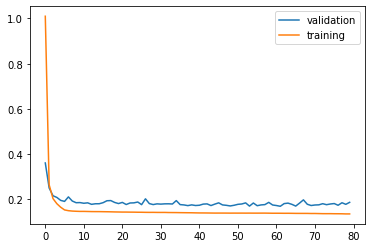

In [102]:
plt.plot(history.history['val_mae'], label = "validation")
plt.plot(history.history['mae'], label = "training")
plt.legend()
plt.show()

In [103]:
test_labels = pd.DataFrame(modelo.test_labels)
prediction_test = pd.DataFrame(modelo.prediction_test)

test_labels['data'] = modelo.test_labels.index
prediction_test['data'] = modelo.test_labels.index

test_labels['mes'] = [mes for mes in modelo.mes]
prediction_test['mes'] = [mes for mes in modelo.mes]

test_labels_gruopby_data = test_labels.groupby(['data']).mean()
prediction_test_gruopby_data = prediction_test.groupby(['data']).mean()

test_labels_gruopby_month = test_labels.groupby(['mes']).mean()
prediction_test_gruopby_month = prediction_test.groupby(['mes']).mean()

test_labels['estacao_id'] = [id for id in modelo.estacao_id ]
prediction_test['estacao_id'] = [id for id in modelo.estacao_id ]

display(prediction_test)

,0,data,mes,estacao_id
0,5.239312,2019-01-02,01,13.0
1,6.190528,2019-01-02,01,8.0
2,3.806422,2019-01-02,01,0.0
3,6.144284,2019-01-02,01,3.0
4,6.494369,2019-01-02,01,1.0
...,...,...,...,...
10384,2.827294,2021-11-25,11,6.0
10385,5.823635,2021-11-25,11,9.0
10386,5.929089,2021-11-25,11,4.0
10387,4.006355,2021-11-25,11,0.0


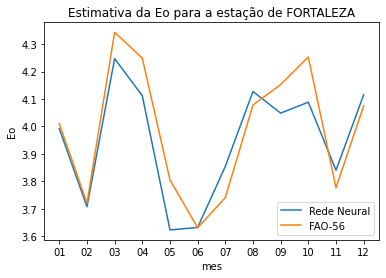

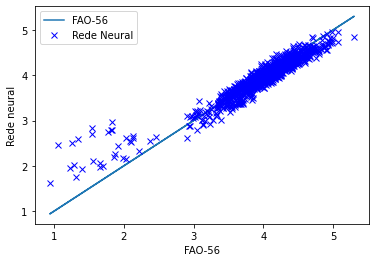

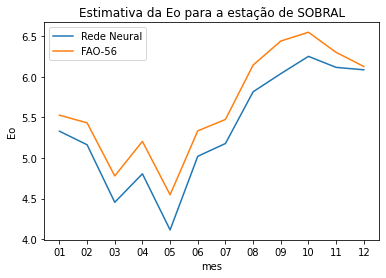

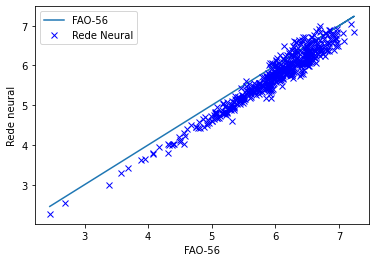

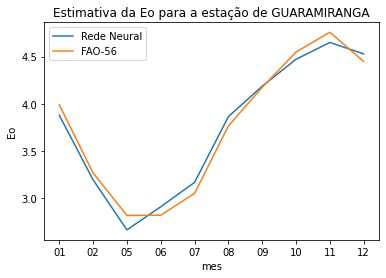

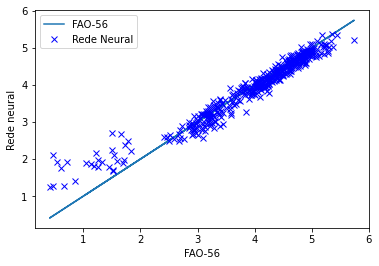

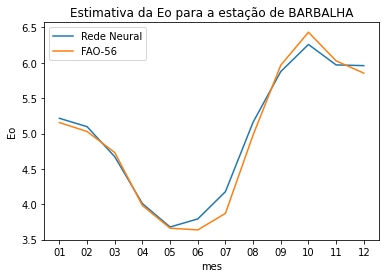

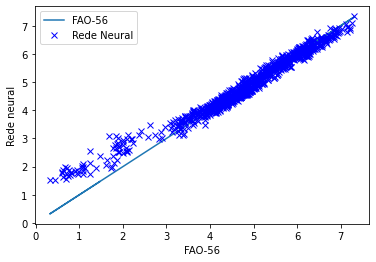

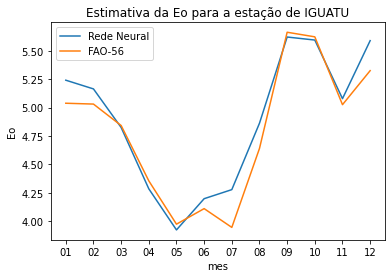

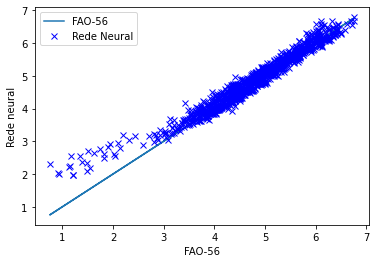

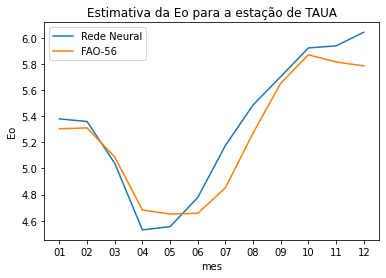

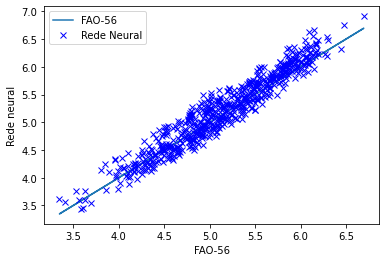

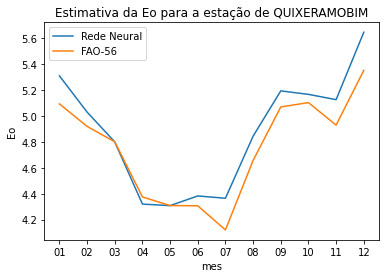

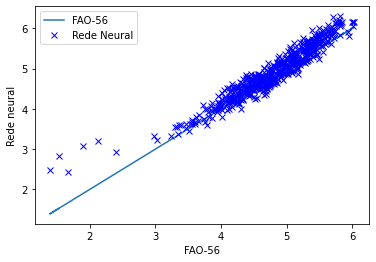

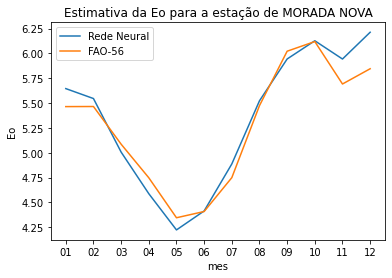

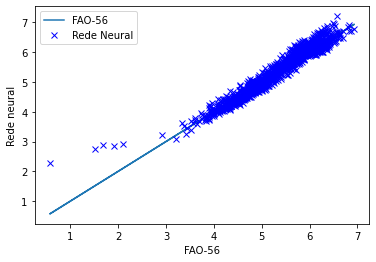

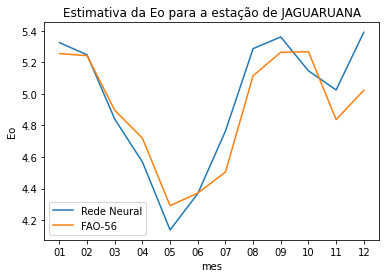

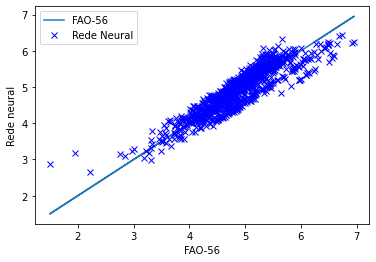

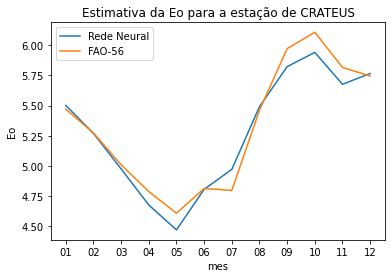

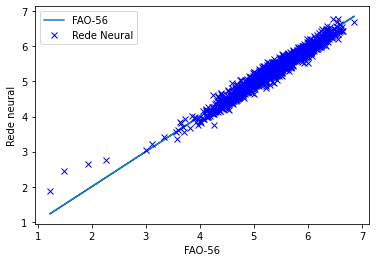

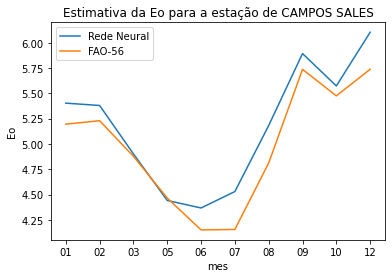

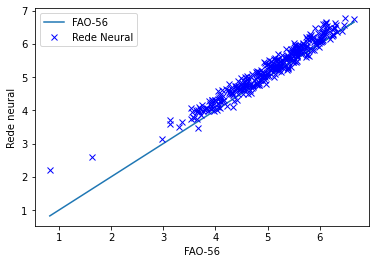

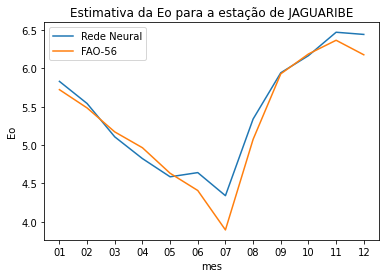

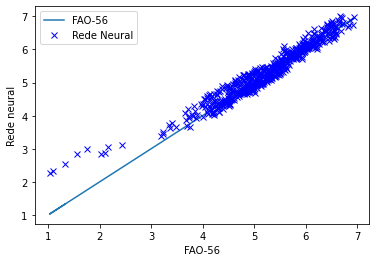

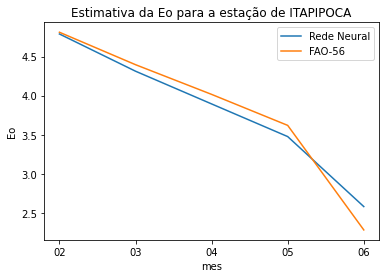

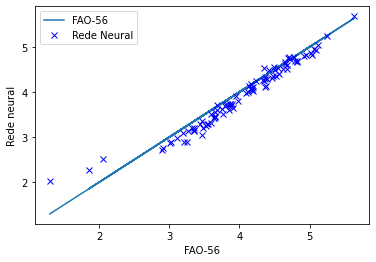

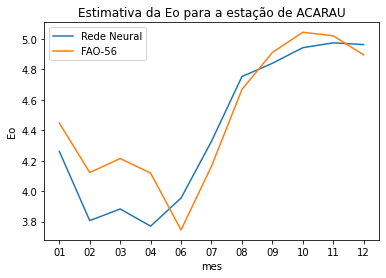

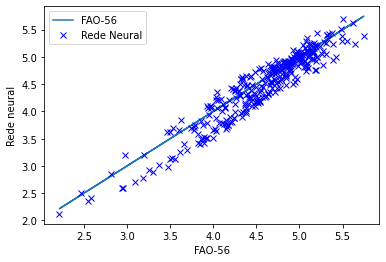

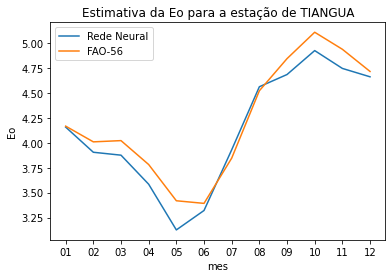

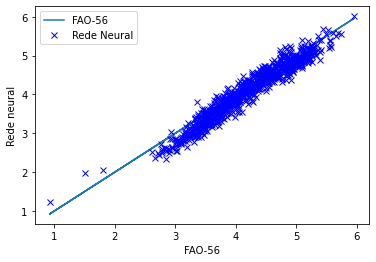

In [104]:
results_by_estation = get_graph_and_metrics_grouped_by_estacao_id(prediction_test,test_labels,'mes',localization,id_2,show_picture = True)

In [105]:
display(results_by_estation.T)

,código da estação,Quantidade de dados,coeficiente de determinação(dia),MSE(dia),coeficiente de determinação(mes),MSE(mes)
FORTALEZA,A305,985,0.888905,0.036059,0.754783,0.010071
SOBRAL,A306,505,0.786166,0.096371,0.789342,0.095383
GUARAMIRANGA,A314,421,0.93064,0.07021,0.979402,0.009631
BARBALHA,A315,928,0.952646,0.082244,0.976658,0.018028
IGUATU,A319,1006,0.941684,0.054161,0.920951,0.025746
TAUA,A324,601,0.89641,0.03879,0.903094,0.024592
QUIXERAMOBIM,A325,550,0.873753,0.054026,0.860081,0.025638
MORADA NOVA,A332,1038,0.93456,0.039992,0.940745,0.026038
JAGUARUANA,A339,1058,0.809396,0.075041,0.821518,0.028818
CRATEUS,A342,992,0.953636,0.02233,0.949049,0.011279


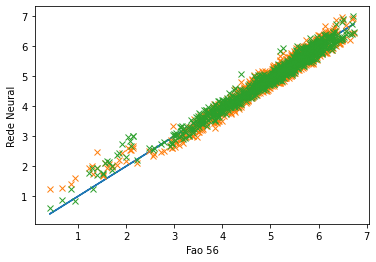

0.9414669097326465


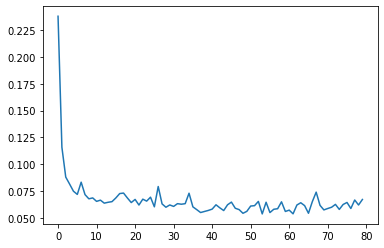

In [106]:
modelo.compare(1000,True)
plt.plot(history.history['val_loss'])
plt.show()

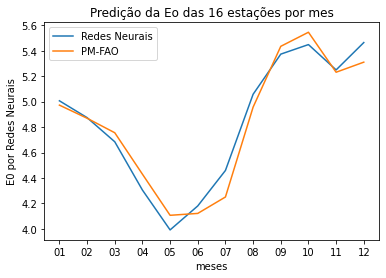

0.9553756596264039

In [107]:
plt.plot(prediction_test_gruopby_month, label = 'Redes Neurais')
plt.plot(test_labels_gruopby_month, label = 'PM-FAO')
plt.legend()
plt.xlabel('meses')
plt.ylabel('E0 por Redes Neurais')
plt.title('Predição da Eo das 16 estações por mes')
plt.show()

display(r2_score(prediction_test_gruopby_month,test_labels_gruopby_month))